In [69]:
!pip install tensorflow==2.10
!pip install keras
!pip install git+https://github.com/philipperemy/keras-tcn.git

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
ERROR: Could not find a version that satisfies the requirement tensorflow==2.10 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow==2.10


Defaulting to user installation because normal site-packages is not writeable

DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/philipperemy/keras-tcn.git to c:\users\lapto\appdata\local\temp\pip-req-build-yh3si72l
  Resolved https://github.com/philipperemy/keras-tcn.git to commit 75b598e01b58d2e2976c8b2c90665f31406c8773
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of keras-tcn to determine which version is compatible with other requirements. This could take a while.


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Running command git clone --filter=blob:none --quiet https://github.com/philipperemy/keras-tcn.git 'C:\Users\lapto\AppData\Local\Temp\pip-req-build-yh3si72l'
ERROR: Could not find a version that satisfies the requirement tensorflow_addons (from keras-tcn) (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow_addons


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tcn import TCN
import matplotlib.dates as mdates
from sklearn.metrics import r2_score
import scipy.stats as stats

In [71]:
# Memuat dataset dari file CSV
dataframe = pd.read_csv('TOTAL_WAVE_PC-C2_HsTpDir_formatted.csv', sep=';')
dataframe['datetime'] = pd.to_datetime(dataframe[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']])
dataframe.set_index('datetime', inplace=True)

In [72]:
dataframe

,Year,Month,Day,Hour,Minute,Second,Wave_Height,Wave_Period,Wave_Direction
datetime,,,,,,,,,
2015-01-01 00:00:00,2015,1.0,1.0,0.0,0.0,0.0,1.49,12.34,211.8
2015-01-01 01:30:00,2015,1.0,1.0,1.0,30.0,0.0,1.50,12.31,212.3
2015-01-01 03:00:00,2015,1.0,1.0,3.0,0.0,0.0,1.51,12.28,212.8
2015-01-01 04:30:00,2015,1.0,1.0,4.0,30.0,0.0,1.53,12.25,213.1
2015-01-01 06:00:00,2015,1.0,1.0,6.0,0.0,0.0,1.54,12.23,213.2
...,...,...,...,...,...,...,...,...,...
2024-01-14 18:00:00,2024,1.0,14.0,18.0,0.0,0.0,1.65,12.59,207.5
2024-01-14 19:30:00,2024,1.0,14.0,19.0,30.0,0.0,1.65,12.60,207.5
2024-01-14 21:00:00,2024,1.0,14.0,21.0,0.0,0.0,1.64,12.61,207.5


In [73]:
# Menggunakan hanya kolom "Wave_Height" untuk prediksi
dataset = dataframe[['Wave_Height']].values
dataset = dataset.astype('float32')

In [74]:
# Normalisasi dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [75]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [76]:
# Tentukan batas waktu untuk data training dan testing
train_start_date = '2018-03-31 22:30:00'  # Mulai dari 1 Januari 2015 jam 00:00:00
train_end_date = '2023-03-31 22:30:00'    # Sampai 31 Desember 2019 jam 23:59:59
test_start_date = '2023-04-01 00:00:00'   # Mulai dari 1 Januari 2020 jam 00:00:00
test_end_date = '2024-01-15 00:00:00'     # Sampai 31 Desember 2021 jam 23:59:59


# Memilih data pelatihan (training) dan pengujian (testing) berdasarkan tanggal
train = dataframe.loc[train_start_date:train_end_date, 'Wave_Height'].values
test = dataframe.loc[test_start_date:test_end_date, 'Wave_Height'].values


In [77]:
# Normalisasi data
train = scaler.transform(train.reshape(-1, 1))
test = scaler.transform(test.reshape(-1, 1))

In [78]:
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [79]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [80]:
# Melihat beberapa data pelatihan dan pengujian
print(f"Data training shape: {trainX.shape}, Data testing shape: {testX.shape}")

Data training shape: (29192, 24, 1), Data testing shape: (4600, 24, 1)


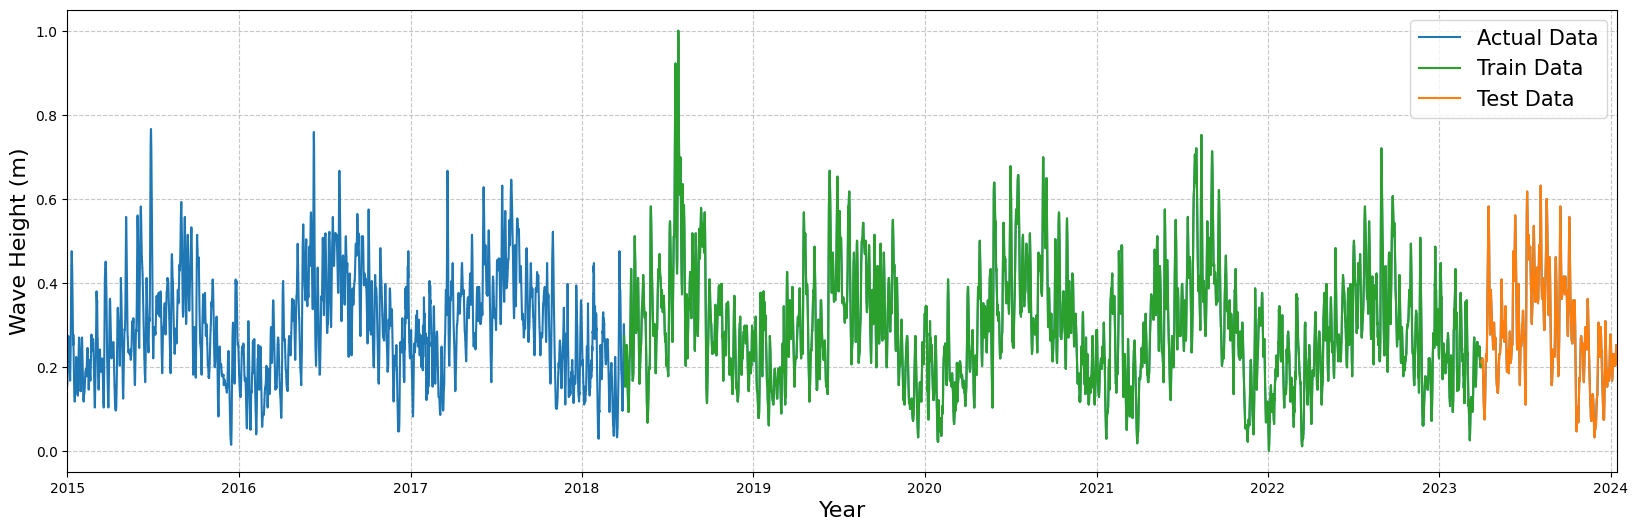

In [81]:
# Visualisasi perbandingan antara data asli, data training, dan data testing
plt.figure(figsize=(20, 6))

# Plot Data Asli (Full Dataset)
plt.plot(dataframe.index, dataset, label='Actual Data', color='#1f77b4')

# Plot Data Training
train_index = dataframe.loc[train_start_date:train_end_date].index
plt.plot(train_index, train, label='Train Data', color='#2ca02c')

# Plot Data Testing
test_index = dataframe.loc[test_start_date:test_end_date].index
plt.plot(test_index, test, label='Test Data', color='#ff7f0e')

# Grid dan batas sumbu x
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(dataframe.index.min(), dataframe.index.max())

# Memberikan judul dan label pada plot
plt.xlabel('Year', fontsize=16)
plt.ylabel('Wave Height (m)', fontsize=16)

# Menampilkan legenda dengan ukuran lebih besar
plt.legend(prop={'size': 15})

# Menampilkan plot
plt.show()


In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from keras.callbacks import EarlyStopping

In [83]:
# Fungsi untuk membuat model TCN
def build_model(nb_filters=64, kernel_size=3, dilations=[1, 2, 4], dropout_rate=0.2, nb_stacks=1):
    model = Sequential([
        TCN(nb_filters=nb_filters, kernel_size=kernel_size, dilations=dilations,
            dropout_rate=dropout_rate, nb_stacks=nb_stacks, input_shape=(10, 1)),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Wrapper untuk scikit-learn menggunakan scikeras
model = KerasRegressor(
    model=build_model,
    verbose=0,
    callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)]  # Early stopping
)

# Ruang pencarian hyperparameter yang disederhanakan
param_distributions = {
    'model__nb_filters': [64, 128],
    'model__kernel_size': [2, 3],
    'model__dilations': [[1, 2, 4], [1, 2, 4, 8]],
    'model__dropout_rate': [0.1, 0.2],
    'model__nb_stacks': [1, 2],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Random search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=10,  # Jumlah iterasi tetap
    cv=2,       # Mengurangi jumlah fold CV
    verbose=1,
    random_state=42
)

# Melatih model
random_search.fit(trainX, trainY)

# Menampilkan hyperparameter terbaik
print("Best hyperparameters:", random_search.best_params_)

# Evaluasi model terbaik
model = random_search.best_estimator_

Fitting 2 folds for each of 10 candidates, totalling 20 fits


C:\Users\lapto\AppData\Roaming\Python\Python312\site-packages\tcn\tcn.py:227: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
C:\Users\lapto\AppData\Roaming\Python\Python312\site-packages\tcn\tcn.py:227: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
C:\Users\lapto\AppData\Roaming\Python\Python312\site-packages\tcn\tcn.py:227: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
C:\Users\lapto\AppData\Roaming\Python\Python312\site-packages\tcn\tcn.py:227: UserWarning: Do not pa

Best hyperparameters: {'model__nb_stacks': 1, 'model__nb_filters': 64, 'model__kernel_size': 2, 'model__dropout_rate': 0.2, 'model__dilations': [1, 2, 4, 8], 'epochs': 30, 'batch_size': 16}


In [84]:
# Function to reverse normalization and calculate metrics
def evaluate_predictions(testY, testPredict, scaler, num_steps):
    # Reverse normalization
    testY_actual = scaler.inverse_transform(testY[:num_steps].reshape(-1, 1))
    testPredict_actual = scaler.inverse_transform(testPredict[:num_steps])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(testY_actual, testPredict_actual))
    r2 = r2_score(testY_actual, testPredict_actual)
    
    return rmse, r2

In [85]:
# Fungsi untuk menghitung RMSE kumulatif
def calculate_cumulative_rmse(actual, predicted):
    cumulative_rmse = []
    cumulative_error = 0
    for i in range(1, len(actual) + 1):
        cumulative_error += mean_squared_error(actual[:i], predicted[:i])
        cumulative_rmse.append(np.sqrt(cumulative_error / i))  # Hitung RMSE untuk semua langkah hingga i
    return cumulative_rmse

In [86]:
# Fungsi untuk menghitung MAPE
def MAPE(x, y):
    result = 0
    for i in range(len(x)):
        result += abs((x[i] - y[i]) / x[i])
    result /= len(x)
    result *= 100
    return result

In [87]:
def RMSPE(x, y):
    result = 0
    for i in range(len(x)):
        result += ((x[i] - y[i]) / x[i]) ** 2
    result /= len(x)
    result = np.sqrt(result)  # Ambil akar kuadrat
    result *= 100  # Mengubah ke dalam bentuk persentase
    return result

In [88]:
# Fungsi untuk menghitung Normalized R-squared
def normalized_r_squared(y_actual, y_predicted):
    """
    Menghitung R-squared yang tidak terpengaruh oleh skala data.
    """
    # Normalisasi data aktual dan prediksi
    y_actual_normalized = (y_actual - np.mean(y_actual)) / np.std(y_actual)
    y_predicted_normalized = (y_predicted - np.mean(y_predicted)) / np.std(y_predicted)
    
    # Hitung variabilitas
    ss_total = np.sum((y_actual_normalized - np.mean(y_actual_normalized)) ** 2)
    ss_residual = np.sum((y_actual_normalized - y_predicted_normalized) ** 2)
    
    # Hitung R-squared
    r_squared_normalized = 1 - (ss_residual / ss_total)
    return r_squared_normalized

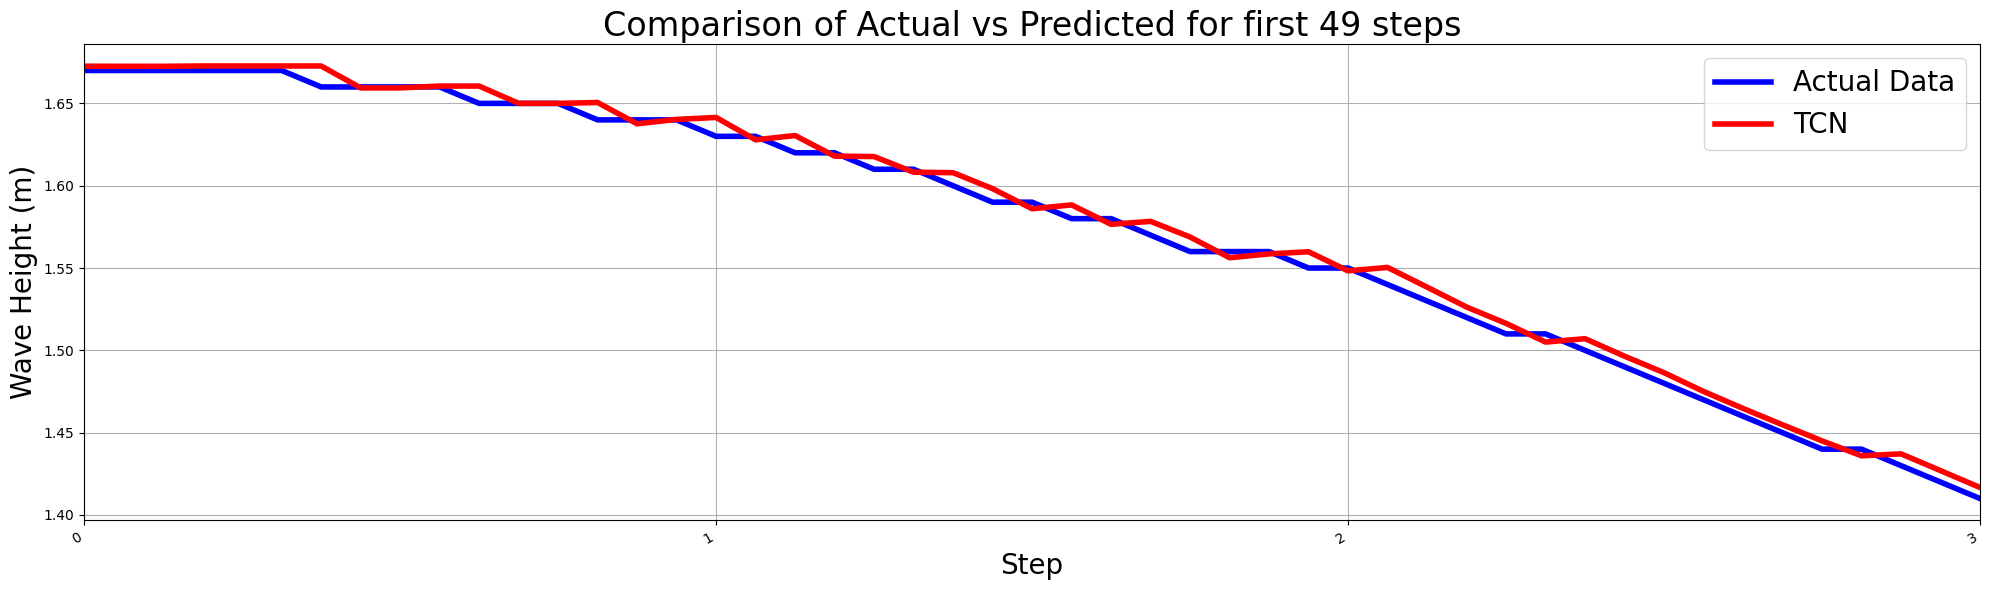

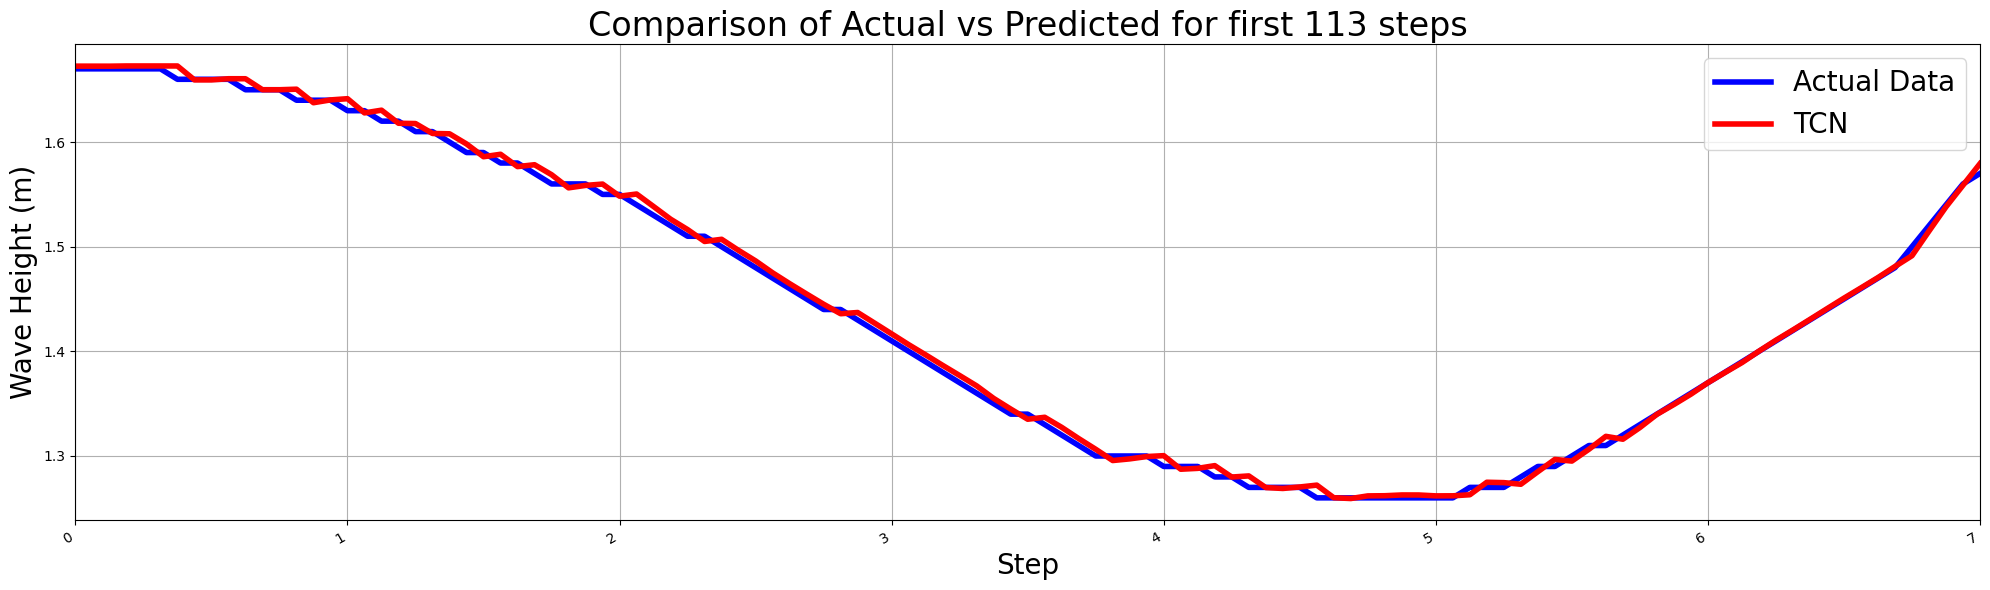

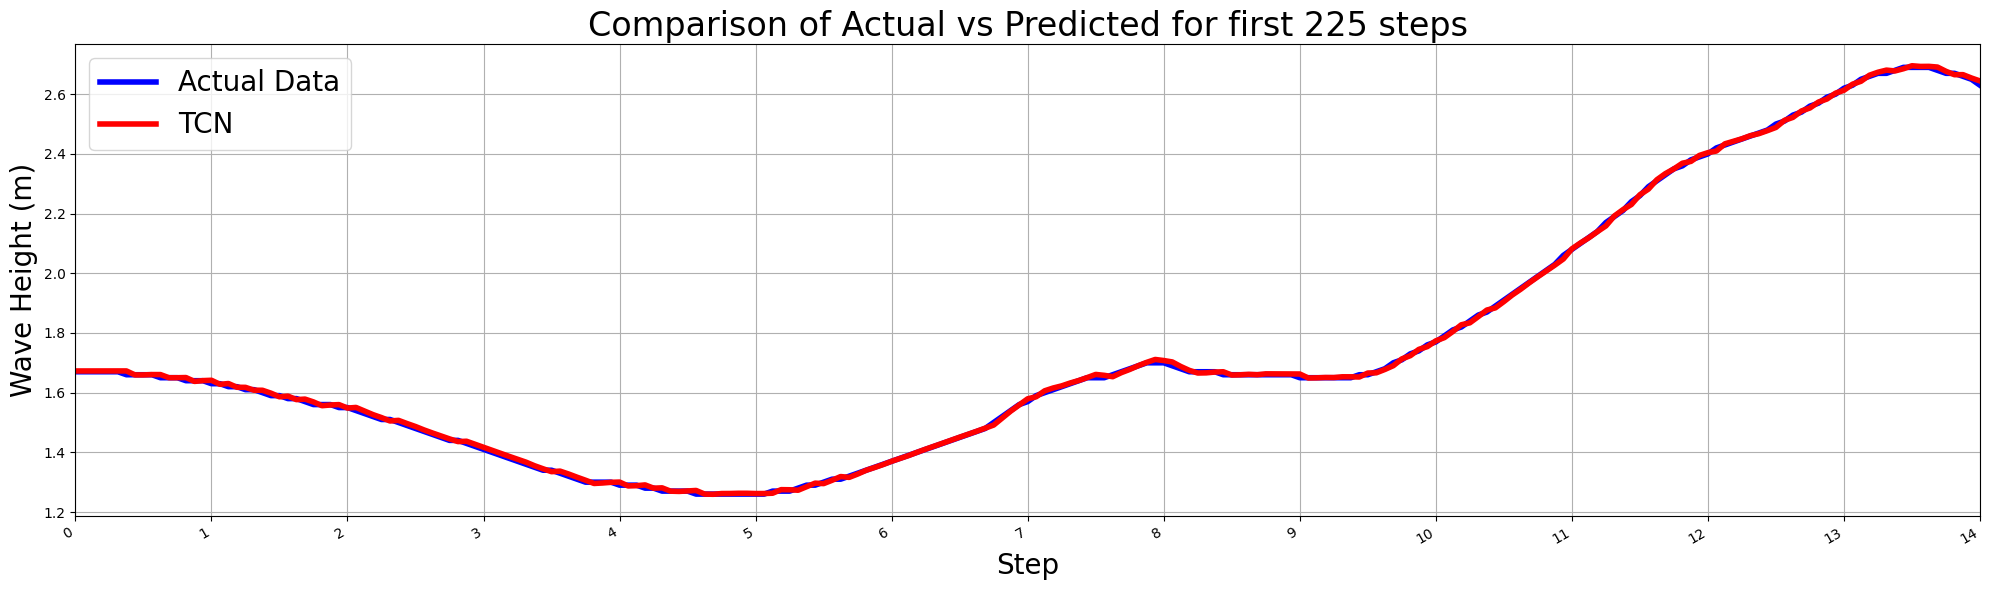

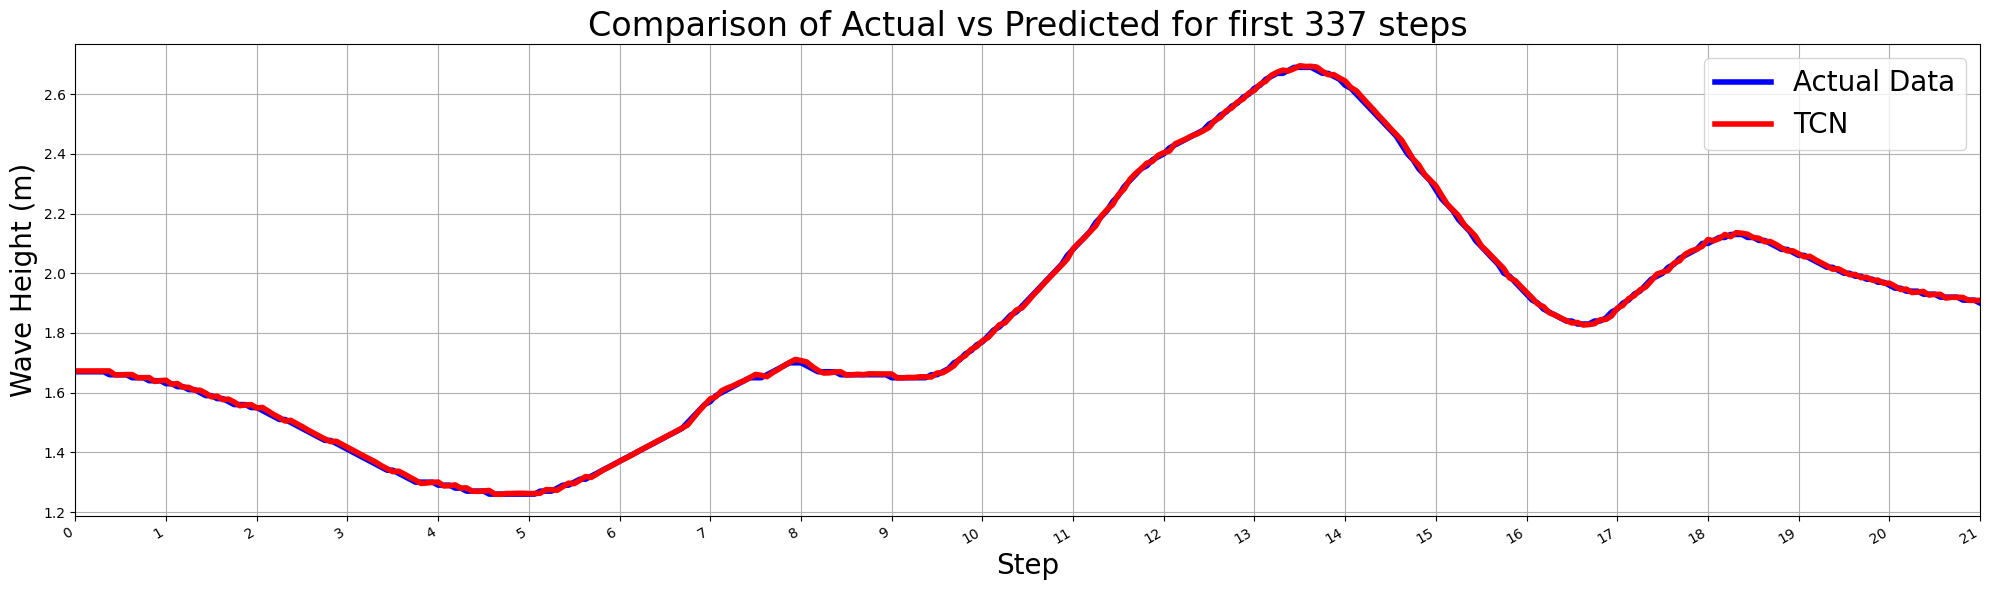

In [99]:
import matplotlib.pyplot as plt

# Daftar horizon prediksi (jumlah langkah)
step = [49,113, 225, 337]

# Loop untuk mengevaluasi setiap horizon
for num_steps in step:
    testPredict = model.predict(testX[:num_steps])
    testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))

    testY_actual = scaler.inverse_transform(testY[:num_steps].reshape(-1, 1))

    # Plot perbandingan antara data aktual dan prediksi
    plt.figure(figsize=(20, 6))
    plt.plot(testY_actual, label='Actual Data', color='blue', linewidth=4)
    plt.plot(testPredict, label='TCN', color='red', linewidth=4)

    # Menetapkan sumbu X untuk setiap 16 data
    step_size = 16
    x_ticks = range(0, len(testY_actual), step_size)
    x_labels = range(len(x_ticks))

    plt.gca().set_xticks(x_ticks)
    plt.gca().set_xticklabels(x_labels)
    plt.gcf().autofmt_xdate()

    plt.title(f'Comparison of Actual vs Predicted for first {num_steps} steps', fontsize=24)
    plt.xlabel('Step', fontsize=20)
    plt.ylabel('Wave Height (m)', fontsize=20)
    plt.grid(True)
    plt.legend(prop={'size': 20})

    # Menempelkan plot ke frame
    plt.gca().set_xlim(left=0, right=len(testY_actual) - 1)  # Menempelkan garis pada sisi kiri dan kanan
    plt.tight_layout()  # Mengurangi margin kosong

    plt.show()


In [100]:
# Daftar horizon prediksi (jumlah langkah)
step = [49,113, 225, 337]

# Loop untuk mengevaluasi setiap horizon
for num_steps in step:
    testPredict = model.predict(testX[:num_steps])
    testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))

    testY_actual = scaler.inverse_transform(testY[:num_steps].reshape(-1, 1))

    # Menghitung metrik evaluasi
    mape_value = MAPE(testY_actual.flatten(), testPredict.flatten())
    rmspe_value = RMSPE(testY_actual.flatten(), testPredict.flatten())
    rmse, r2 = evaluate_predictions(testY_actual, testPredict, scaler, num_steps)

        # Hitung Normalized R²
    r2_normalized = normalized_r_squared(testY_actual.flatten(), testPredict.flatten())

    print(f'RMSE for first {num_steps} predictions: {rmse:.4f}')
    print(f'Normalized R-squared for first {num_steps} predictions: {r2:.4f}')

RMSE for first 3 predictions: O.0170
Normalized R-squared for first 3 predictions: 0.9930
RMSE for first 7 predictions: 0.0175
Normalized R-squared for first 7 predictions: 0.9898
RMSE for first 14 predictions: 0.0178
Normalized R-squared for first 14 predictions: 0.9871
RMSE for first 21 predictions: 0.0172
Normalized R-squared for first 21 predictions: 0.9870
